# Master Thesis

Datasets:
- medical dataset: https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions/data
- pii masking hugging face dataset: https://huggingface.co/datasets/ai4privacy/pii-masking-65k/viewer/default/train?row=2

Github:
- https://github.com/kkdresen/masterds_thesis

In [1]:
!pip install lime


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


### Packages

In [147]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import random
import itertools
from collections import defaultdict
from nltk.tokenize import sent_tokenize, word_tokenize
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch

%matplotlib inline

### Load in Medical Data

In [148]:
path = "/Users/kyradresen/MasterThesis_MedTextPrivacy/data/mtsamples.csv"
data = pd.read_csv(path)
print(data.shape)
data.head()

(4999, 6)


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [149]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


### Missing Values

In [150]:
print(data.isnull().sum())

Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64


In [151]:
# drop rows where transcription is na

data = data.dropna(subset=['transcription'])
data.isnull().sum()

Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription           0
keywords             1068
dtype: int64

The dataset contains of several categories, but we will need only transcription, and medical_specialty, which is the target disgnostics type.

In [152]:
# Select only the specified columns
data = data[['medical_specialty', 'transcription']]

In [153]:
data.shape

(4966, 2)

## Data review

In [154]:
data['medical_specialty'].value_counts()

medical_specialty
Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    61
Psychiatry / Psychology            53
Office Notes                       50
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                       

In [155]:
# number of specialties
len(data.medical_specialty.unique())

40

In [156]:
def get_sentence_word_count(transcriptions):
    sentence_count = sum(len(sent_tokenize(text)) for text in transcriptions)
    words = [word for text in transcriptions for word in word_tokenize(text)]
    unique_words = set(words)
    return sentence_count, len(unique_words)

# Filter out rows where 'transcription' is NaN
data = data[data['transcription'].notna()]

# Convert 'transcription' column to a list of strings for processing
transcriptions = data['transcription'].tolist()

# Get sentence and unique word counts
sent_count, word_count = get_sentence_word_count(transcriptions)

print("Number of sentences in transcriptions column: " + str(sent_count))
print("Number of unique words in transcriptions column: " + str(word_count))

Number of sentences in transcriptions column: 147006
Number of unique words in transcriptions column: 41910


In [157]:
# Ensure NLTK resources are downloaded (only need to do this once)
nltk.download('punkt')

def analyze_transcription_metrics(transcription):
    # Tokenize the transcription into sentences and words
    sentences = sent_tokenize(transcription)
    words = word_tokenize(transcription)

    # Calculate metrics
    word_count = len(words)
    mean_word_length = sum(len(word) for word in words) / word_count
    mean_sentence_length = sum(len(sentence.split()) for sentence in sentences) / len(sentences)
    length_of_sample_review = len(transcription)  # Length of the sample review

    return {
        "Word count": word_count,
        "Mean word length": mean_word_length,
        "Mean sentence length": mean_sentence_length,
        "Length of sample review": length_of_sample_review,
        "Number of words in review": word_count,  # This is the same as word_count
        "Avg length of words": mean_word_length,  # This is the same as mean_word_length
        "Avg length of sentences in review": mean_sentence_length,  # Same as mean_sentence_length
    }

# Assuming 'data' is your DataFrame and it has a 'transcription' column
# Filter out rows where 'transcription' is NaN
data = data[data['transcription'].notna()]

# Apply the analysis to each transcription and create a new DataFrame with the results
metrics = data['transcription'].apply(analyze_transcription_metrics)
metrics_df = pd.DataFrame(metrics.tolist())

# Calculate mean, min, and max for each metric
metrics_summary = pd.DataFrame({
    "Mean": metrics_df.mean(),
    "Min": metrics_df.min(),
    "Max": metrics_df.max()
})

print(metrics_summary)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kyradresen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                          Mean    Min           Max
Word count                          553.022553   3.00   3489.000000
Mean word length                      4.649653   3.25      7.333333
Mean sentence length                 16.921946   1.00    114.000000
Length of sample review            3052.314337  11.00  18425.000000
Number of words in review           553.022553   3.00   3489.000000
Avg length of words                   4.649653   3.25      7.333333
Avg length of sentences in review    16.921946   1.00    114.000000


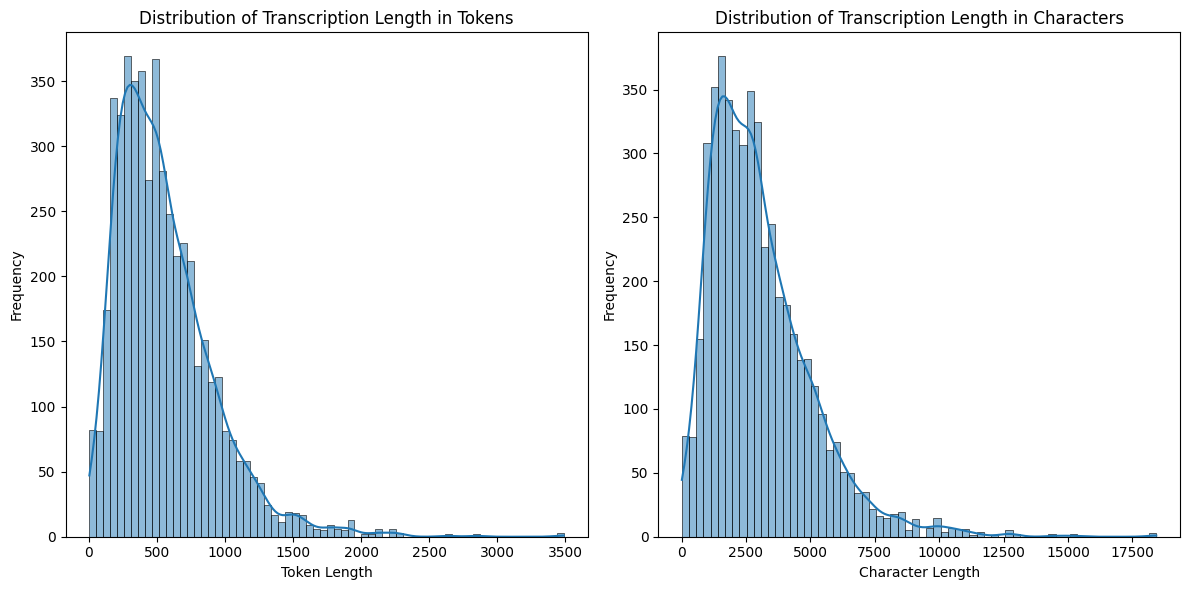

In [158]:
def analyze_transcription_lengths(transcription):
    """
    Analyze the length of a transcription in both tokens and characters.

    :param transcription: The transcription text.
    :return: A dictionary with token and character lengths.
    """
    tokens = word_tokenize(transcription)
    token_length = len(tokens)
    character_length = len(transcription)

    return {
        "Token Length": token_length,
        "Character Length": character_length
    }

# Assuming 'data' is your DataFrame and it has a 'transcription' column
# Filter out rows where 'transcription' is NaN
data = data[data['transcription'].notna()]

# Apply the analysis to each transcription and create a new DataFrame with the results
length_metrics = data['transcription'].apply(analyze_transcription_lengths)
length_metrics_df = pd.DataFrame(length_metrics.tolist())

def plot_transcription_length_distributions(length_metrics_df):
    """
    Plot the distribution of transcription lengths in tokens and characters.

    :param length_metrics_df: DataFrame with 'Token Length' and 'Character Length' columns.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot token length distribution
    sns.histplot(length_metrics_df['Token Length'], ax=ax[0], kde=True)
    ax[0].set_title('Distribution of Transcription Length in Tokens')
    ax[0].set_xlabel('Token Length')
    ax[0].set_ylabel('Frequency')

    # Plot character length distribution
    sns.histplot(length_metrics_df['Character Length'], ax=ax[1], kde=True)
    ax[1].set_title('Distribution of Transcription Length in Characters')
    ax[1].set_xlabel('Character Length')
    ax[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plotting the distributions
plot_transcription_length_distributions(length_metrics_df)

## Data Pre-processing
### Filtering Dataset with Domain Expertise

 The surgey category is kind of superset as there can be surgeries belonging to specializations like cardiology,neurolrogy etc. Similarly other categories like Emergency Room Reports, Discharge Summary, Notes also overlap with specialities. These categories are either merged or removed

In [159]:
import pandas as pd

def filter_specialties(data, exclude_specialties):
    # Strip whitespace from 'medical_specialty' column
    data['medical_specialty'] = data['medical_specialty'].str.strip()

    # Filter out rows with specified medical specialties
    data = data[~data['medical_specialty'].isin(exclude_specialties)]

    # Consolidate specific specialties
    data.loc[data['medical_specialty'] == 'Neurosurgery', 'medical_specialty'] = 'Neurology'
    data.loc[data['medical_specialty'] == 'Nephrology', 'medical_specialty'] = 'Urology'

    # Filter out categories with fewer than 50 entries
    #data = data.groupby('medical_specialty').filter(lambda x: x.shape[0] > 50)

    # Group by 'medical_specialty' to check the categories and their counts
    final_data_categories = data.groupby('medical_specialty')

    # Display reduced categories
    print('============Reduced Categories======================')
    for i, (catName, dataCategory) in enumerate(final_data_categories, 1):
        print(f'Cat:{i} {catName} : {len(dataCategory)}')
    print('============Reduced Categories======================')

    # Drop rows with NaN in 'transcription'
    data = data.dropna(subset=['transcription'])

    return data

In [160]:
# List of specialties to be excluded
exclude_specialties = [
    'Surgery', 'SOAP / Chart / Progress Notes', 'Office Notes',
    'Consult - History and Phy.', 'Emergency Room Reports',
    'Discharge Summary', 'Pain Management', 'General Medicine'
]

# Example usage
# Assuming 'filtered_data_categories' is your DataFrame
# filtered_data_categories = pd.read_csv('your_data.csv') # Replace with your data loading method
data = filter_specialties(data, exclude_specialties)
print(data.shape)

============Reduced Categories======================
Cat:1 Allergy / Immunology : 7
Cat:2 Autopsy : 8
Cat:3 Bariatrics : 18
Cat:4 Cardiovascular / Pulmonary : 371
Cat:5 Chiropractic : 14
Cat:6 Cosmetic / Plastic Surgery : 27
Cat:7 Dentistry : 27
Cat:8 Dermatology : 29
Cat:9 Diets and Nutritions : 10
Cat:10 ENT - Otolaryngology : 96
Cat:11 Endocrinology : 19
Cat:12 Gastroenterology : 224
Cat:13 Hematology - Oncology : 90
Cat:14 Hospice - Palliative Care : 6
Cat:15 IME-QME-Work Comp etc. : 16
Cat:16 Lab Medicine - Pathology : 8
Cat:17 Letters : 23
Cat:18 Neurology : 317
Cat:19 Obstetrics / Gynecology : 155
Cat:20 Ophthalmology : 83
Cat:21 Orthopedic : 355
Cat:22 Pediatrics - Neonatal : 70
Cat:23 Physical Medicine - Rehab : 21
Cat:24 Podiatry : 47
Cat:25 Psychiatry / Psychology : 53
Cat:26 Radiology : 273
Cat:27 Rheumatology : 10
Cat:28 Sleep Medicine : 20
Cat:29 Speech - Language : 9
Cat:30 Urology : 237
============Reduced Categories======================
(2643, 2)


## Retrieve three sentences of transcription due to computational constraints

In [161]:
import pandas as pd
import re

def extract_age_related_sentences(df):
    """
    Extracts sentences containing the pattern '-year-old', 'y/o', 'patient', 'gentleman', 'he', 'she', 'female', 'parents', 'baby', or 'child'
    and the following two sentences from medical report transcriptions, adds these to a new column,
    and leaves the cell empty if no match is found. If the following two sentences are less than 45 words combined, 
    it will take up to 45 words from those sentences.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the full text of medical reports.

    Returns:
    pandas.DataFrame: Updated DataFrame with a new column 'age_related_sentence'.
    """
    # Compile the regular expression pattern for finding "-year-old", "y/o", "patient", "gentleman", "he", "she", "male", "female", "parents", "baby", "child" and the following two sentences
    pattern = re.compile(r'\b([^\.!?]*?\b(?:old|y/o|patient|gentleman|he|she|male|female|parents|baby|child|infant)\b[^\.!?]*[\.!?])\s*([^\.!?]*[\.!?])\s*([^\.!?]*[\.!?])', re.IGNORECASE)

    # List to store the age-related sentences with the following two sentences
    age_sentences = []

    # Iterate through each transcription in the DataFrame
    for text in df['transcription']:
        # Find all matches in the text
        matches = pattern.findall(text)
        if matches:
            # Take the first match
            first_match = ' '.join(matches[0]).strip()
            words = first_match.split()
            if len(words) < 45:
                # If combined sentences are less than 45 words, add more words from the text
                all_words = text.split()
                match_start_index = text.lower().find(first_match.lower())
                additional_words = all_words[(match_start_index + len(words)):]

                if len(words) + len(additional_words) > 45:
                    words += additional_words[:45 - len(words)]
                else:
                    words += additional_words

                first_match = ' '.join(words)
            age_sentences.append(first_match)
        else:
            # If no matches, append an empty string
            age_sentences.append('')

    # Add the extracted sentences as a new column in the DataFrame
    df['age_related_sentence'] = age_sentences

    return df

# Apply the function to the DataFrame
# Apply the function to the DataFrame
df=data
df = extract_age_related_sentences(df)
print(df[['transcription', 'age_related_sentence']])

                                          transcription  \
0     SUBJECTIVE:,  This 23-year-old white female pr...   
1     PAST MEDICAL HISTORY:, He has difficulty climb...   
2     HISTORY OF PRESENT ILLNESS: , I have seen ABC ...   
3     2-D M-MODE: , ,1.  Left atrial enlargement wit...   
4     1.  The left ventricular cavity size and wall ...   
...                                                 ...   
4994  HISTORY:,  I had the pleasure of meeting and e...   
4995  ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...   
4996  SUBJECTIVE: , This is a 42-year-old white fema...   
4997  CHIEF COMPLAINT: , This 5-year-old male presen...   
4998  HISTORY: , A 34-year-old male presents today s...   

                                   age_related_sentence  
0     SUBJECTIVE:, This 23-year-old white female pre...  
1     PAST MEDICAL HISTORY:, He has difficulty climb...  
2     He is a very pleasant gentleman who is 42 year...  
3                                                        
4

In [162]:
df.shape

(2643, 3)

In [163]:
# Create a new DataFrame df2 that holds all rows where 'age_related_sentence' is empty
df2 = df[df['age_related_sentence'].replace('', pd.NA).isna()]

# Count empty rows in 'age_related_sentence' column
empty_count = df2.shape[0]
print("Number of empty rows:", empty_count)

Number of empty rows: 335


In [164]:
df2

,medical_specialty,transcription,age_related_sentence
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,
7,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",
9,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....",
11,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...",
...,...,...,...
4966,Cardiovascular / Pulmonary,"INDICATIONS:, Peripheral vascular disease wit...",
4967,Cardiovascular / Pulmonary,"EXAM: , Left heart cath, selective coronary an...",
4971,Cardiovascular / Pulmonary,"ANGINA, is chest pain due to a lack of oxygen ...",
4983,Autopsy,"MANNER OF DEATH: , Homicide.,CAUSE OF DEATH:,",


In [165]:
# Drop all rows where 'age_related_sentence' is empty
data = data[data['age_related_sentence'].replace('', pd.NA).notna()]

In [166]:
# This accesses the first row and the column by its position; here we assume 'age_related_sentence' is the first column
df.iloc[5]['age_related_sentence']  # 0 is the index of the first row

'INDICATION FOR PROCEDURE: , This is a 30-year-old female, who has been overweight for many years. She has tried many different diets, but is unsuccessful. She has been to our Bariatric Surgery Seminar, received some handouts, and signed the consent. has tried many different diets,'

In [167]:
import re
import pandas as pd

def extract_text_after_comma(df, column_name):
    """
    Extracts text following the first comma within the first 4 words of the specified column of a DataFrame
    and ensures there are at least two consecutive capital letters forming a word within the first 4 words.
    If the comma is not within the first 4 words, or there are not at least two consecutive capital letters forming a word within the first 4 words,
    the original text is kept.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to process.

    Returns:
    pandas.DataFrame: The DataFrame with an additional column 'extracted_text' containing the extracted text or the original text.
    """
    # List to store the extracted text
    extracted_text = []

    # Regular expression to find at least two consecutive capital letters forming a word
    capital_letter_pattern = re.compile(r'\b[A-Z]{2,}\b')

    # Iterate through each row in the specified column
    for text in df[column_name]:
        words = text.split()
        # Find the position of the first comma within the first 4 words
        if len(words) >= 4:
            first_four_words = ' '.join(words[:4])
            remaining_text = ' '.join(words[4:])
            if ',' in first_four_words and capital_letter_pattern.search(first_four_words):
                first_four_words = first_four_words.split(',', 1)[1].strip()
                extracted_text.append(f"{first_four_words} {remaining_text}".strip())
            else:
                extracted_text.append(text)
        else:
            if ',' in text and capital_letter_pattern.search(text):
                extracted_text.append(text.split(',', 1)[1].strip())
            else:
                extracted_text.append(text)

    # Add the extracted text as a new column in the DataFrame
    df['extracted_text'] = extracted_text
    return df

In [168]:
# Apply the function to the DataFrame
data = extract_text_after_comma(data, 'age_related_sentence')
print(data[['age_related_sentence', 'extracted_text']])

                                   age_related_sentence  \
0     SUBJECTIVE:, This 23-year-old white female pre...   
1     PAST MEDICAL HISTORY:, He has difficulty climb...   
2     He is a very pleasant gentleman who is 42 year...   
5     INDICATION FOR PROCEDURE: , This is a 30-year-...   
6     INDICATION FOR OPERATION:,  The patient is a 3...   
...                                                 ...   
4994  HISTORY:,  I had the pleasure of meeting and e...   
4995  HOSPITAL COURSE:,  This is a 14-month-old baby...   
4996  SUBJECTIVE: , This is a 42-year-old white fema...   
4997  CHIEF COMPLAINT: , This 5-year-old male presen...   
4998  HISTORY: , A 34-year-old male presents today s...   

                                         extracted_text  
0     This 23-year-old white female presents with co...  
1     He has difficulty climbing stairs, difficulty ...  
2     He is a very pleasant gentleman who is 42 year...  
5     This is a 30-year-old female, who has been ove...  
6

/var/folders/th/lhv5svr57tl9sd7p465ddg3h0000gn/T/ipykernel_11961/2988448593.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['extracted_text'] = extracted_text


In [169]:
data

,medical_specialty,transcription,age_related_sentence,extracted_text
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr...","SUBJECTIVE:, This 23-year-old white female pre...",This 23-year-old white female presents with co...
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb...","PAST MEDICAL HISTORY:, He has difficulty climb...","He has difficulty climbing stairs, difficulty ..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",He is a very pleasant gentleman who is 42 year...,He is a very pleasant gentleman who is 42 year...
5,Bariatrics,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...","INDICATION FOR PROCEDURE: , This is a 30-year-...","This is a 30-year-old female, who has been ove..."
6,Bariatrics,"PREOPERATIVE DIAGNOSES:,1. Deformity, right b...","INDICATION FOR OPERATION:, The patient is a 3...",The patient is a 31-year-old white female who ...
...,...,...,...,...
4994,Allergy / Immunology,"HISTORY:, I had the pleasure of meeting and e...","HISTORY:, I had the pleasure of meeting and e...",I had the pleasure of meeting and evaluating t...
4995,Allergy / Immunology,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","HOSPITAL COURSE:, This is a 14-month-old baby...",This is a 14-month-old baby boy Caucasian who ...
4996,Allergy / Immunology,"SUBJECTIVE: , This is a 42-year-old white fema...","SUBJECTIVE: , This is a 42-year-old white fema...",This is a 42-year-old white female who comes i...
4997,Allergy / Immunology,"CHIEF COMPLAINT: , This 5-year-old male presen...","CHIEF COMPLAINT: , This 5-year-old male presen...",This 5-year-old male presents to Children's Ho...


/var/folders/th/lhv5svr57tl9sd7p465ddg3h0000gn/T/ipykernel_11961/1644181151.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  word_lengths = data[columns_to_clean].applymap(calculate_word_length)


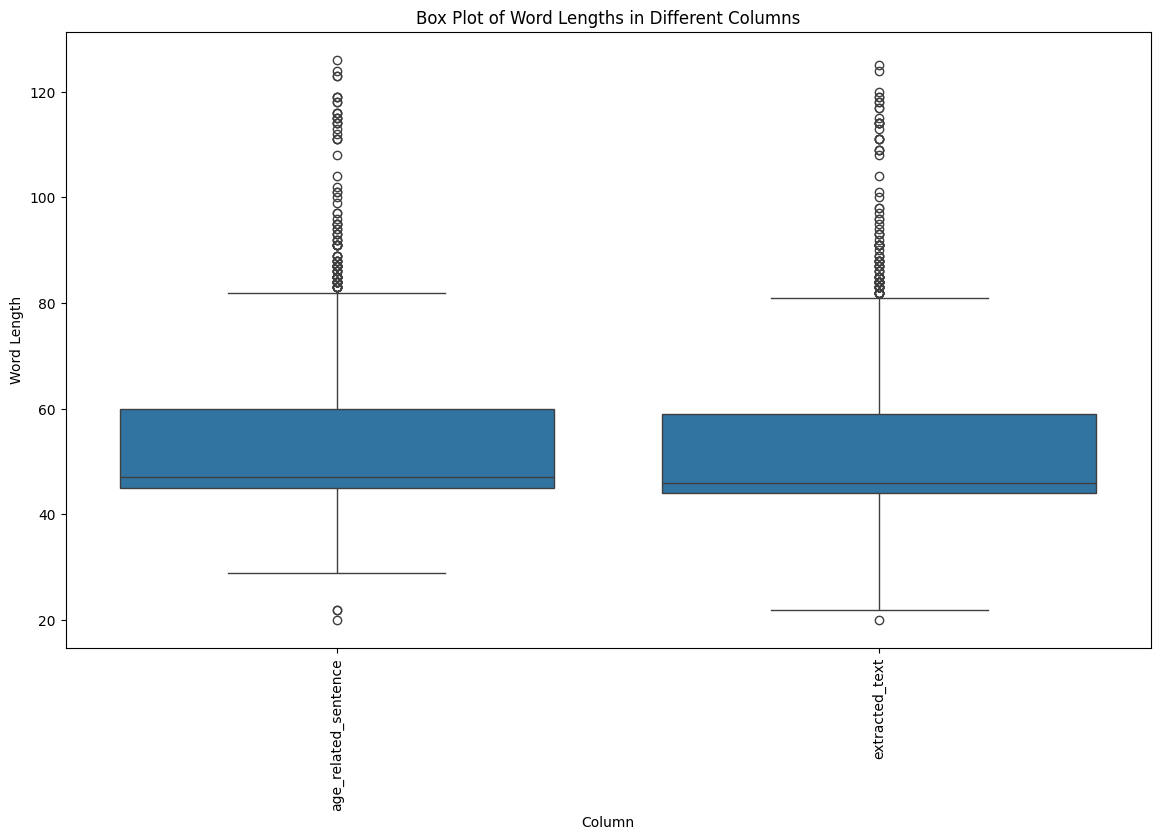

In [134]:
columns_to_clean = [
    'age_related_sentence',
    'extracted_text'
]


# Function to calculate word lengths
def calculate_word_length(text):
    return len(str(text).split())

# Apply the function to each column in columns_to_clean and create a new DataFrame
word_lengths = data[columns_to_clean].applymap(calculate_word_length)

# Melt the DataFrame for plotting
word_lengths_melted = word_lengths.melt(var_name='Column', value_name='Word Length')

# Create a box plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Column', y='Word Length', data=word_lengths_melted)
plt.xticks(rotation=90)
plt.title('Box Plot of Word Lengths in Different Columns')
plt.xlabel('Column')
plt.ylabel('Word Length')
plt.show()


In [135]:
data.shape

(2308, 4)

To fine-tune a model, you are required to provide at least 10 examples. We typically see clear improvements from fine-tuning on 50 to 100 training examples with gpt-3.5-turbo but the right number varies greatly based on the exact use case source(https://community.openai.com/t/can-using-similar-examples-in-the-training-dataset-for-fine-tuning-increase-its-accuracy/714365#:~:text=To%20fine%2Dtune%20a%20model,on%20the%20exact%20use%20case.)

In [178]:
# Filter out categories with fewer than 50 entries
data = data.groupby('medical_specialty').filter(lambda x: x.shape[0] >= 50)

In [179]:
data

,medical_specialty,transcription,age_related_sentence,extracted_text,token_length,char_length
12,Neurology,"CC:, Confusion and slurred speech.,HX , (prima...","HX , (primarily obtained from boyfriend): This...",(primarily obtained from boyfriend): This 31 y...,43,283
16,Cardiovascular/Pulmonary,"PREOPERATIVE DIAGNOSES,Airway obstruction seco...","INDICATIONS FOR SURGERY,The patient is a 50-ye...",The patient is a 50-year-old white male with h...,72,494
18,Urology,"PROCEDURE: , Elective male sterilization via b...","PROCEDURE: , Elective male sterilization via b...",Elective male sterilization via bilateral vase...,43,371
22,Urology,"DESCRIPTION:, The patient was placed in the s...","DESCRIPTION:, The patient was placed in the su...",The patient was placed in the supine position ...,44,253
23,Urology,"PREOPERATIVE DIAGNOSIS: , Voluntary sterility....","INDICATIONS FOR PROCEDURE: ,A gentleman who i...",A gentleman who is here today requesting volun...,63,407
...,...,...,...,...,...,...
4972,Cardiovascular/Pulmonary,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...","TYPE OF TEST: , Adenosine with nuclear scan as...",Adenosine with nuclear scan as the patient una...,41,258
4973,Cardiovascular/Pulmonary,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...","HISTORY OF PRESENT ILLNESS:, The patient is a...",The patient is a 40-year-old white male who pr...,46,286
4974,Cardiovascular/Pulmonary,"HISTORY OF PRESENT ILLNESS: , The patient is a...","HISTORY OF PRESENT ILLNESS: , The patient is a...","HISTORY OF PRESENT ILLNESS: , The patient is a...",62,337
4975,Cardiovascular/Pulmonary,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...",ABC is a 60-year-old gentleman who had a marke...,ABC is a 60-year-old gentleman who had a marke...,119,751


## Clean column names

In [180]:
import pandas as pd

def clean_target_variables(df, target_column):
    """
    Cleans up the target variables by removing all white spaces and removing "ENT - " from the target variable names.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    target_column (str): The name of the target column to clean.

    Returns:
    pandas.DataFrame: The cleaned DataFrame.
    """
    # Remove "ENT - " from the target variable names
    df[target_column] = df[target_column].str.replace(r'\bENT - ', '', regex=True)

    # Remove all white spaces
    df[target_column] = df[target_column].str.replace(' ', '')

    return df

In [181]:
df = data 

In [182]:
# Apply the function to the DataFrame
data = clean_target_variables(data, 'medical_specialty')

In [183]:
data

,medical_specialty,transcription,age_related_sentence,extracted_text,token_length,char_length
12,Neurology,"CC:, Confusion and slurred speech.,HX , (prima...","HX , (primarily obtained from boyfriend): This...",(primarily obtained from boyfriend): This 31 y...,43,283
16,Cardiovascular/Pulmonary,"PREOPERATIVE DIAGNOSES,Airway obstruction seco...","INDICATIONS FOR SURGERY,The patient is a 50-ye...",The patient is a 50-year-old white male with h...,72,494
18,Urology,"PROCEDURE: , Elective male sterilization via b...","PROCEDURE: , Elective male sterilization via b...",Elective male sterilization via bilateral vase...,43,371
22,Urology,"DESCRIPTION:, The patient was placed in the s...","DESCRIPTION:, The patient was placed in the su...",The patient was placed in the supine position ...,44,253
23,Urology,"PREOPERATIVE DIAGNOSIS: , Voluntary sterility....","INDICATIONS FOR PROCEDURE: ,A gentleman who i...",A gentleman who is here today requesting volun...,63,407
...,...,...,...,...,...,...
4972,Cardiovascular/Pulmonary,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...","TYPE OF TEST: , Adenosine with nuclear scan as...",Adenosine with nuclear scan as the patient una...,41,258
4973,Cardiovascular/Pulmonary,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...","HISTORY OF PRESENT ILLNESS:, The patient is a...",The patient is a 40-year-old white male who pr...,46,286
4974,Cardiovascular/Pulmonary,"HISTORY OF PRESENT ILLNESS: , The patient is a...","HISTORY OF PRESENT ILLNESS: , The patient is a...","HISTORY OF PRESENT ILLNESS: , The patient is a...",62,337
4975,Cardiovascular/Pulmonary,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...",ABC is a 60-year-old gentleman who had a marke...,ABC is a 60-year-old gentleman who had a marke...,119,751


In [ ]:
data.to_csv("2016r_mtsamples_final.csv", index=False)

## Token and Transcription length plot of pre-proceseed df (2016 rows)

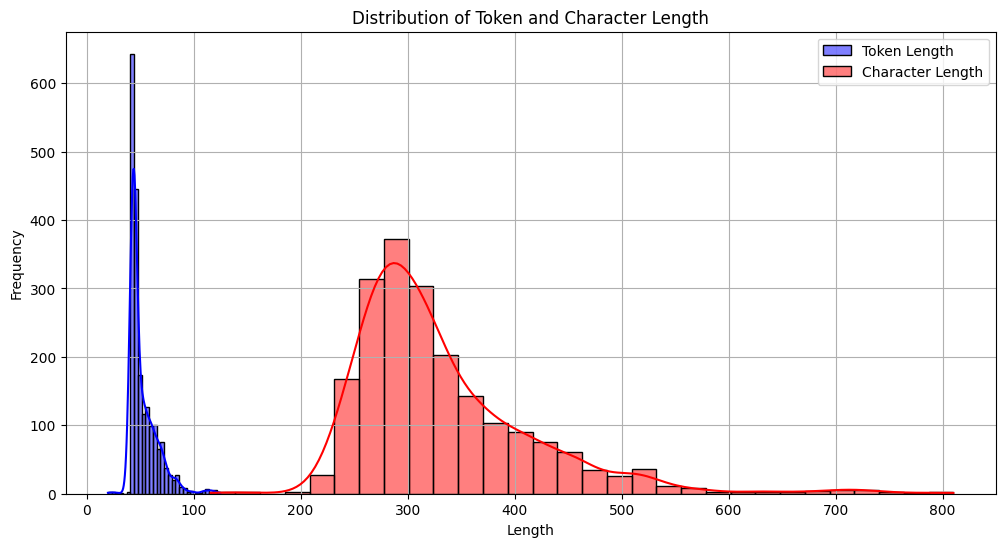

Average token length: 52.3 tokens
Average character length: 332.5 characters
Minimum token length: 20 tokens
Minimum character length: 116 characters
Maximum token length: 125 tokens
Maximum character length: 810 characters


In [184]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_token_character_distribution(df, column):
    # Calculate token and character lengths
    df['token_length'] = df[column].apply(lambda x: len(x.split()))
    df['char_length'] = df[column].apply(lambda x: len(x))
    
    # Calculate statistical information
    avg_token_length = df['token_length'].mean()
    avg_char_length = df['char_length'].mean()
    min_token_length = df['token_length'].min()
    min_char_length = df['char_length'].min()
    max_token_length = df['token_length'].max()
    max_char_length = df['char_length'].max()
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.histplot(df['token_length'], color='blue', label='Token Length', kde=True, bins=30)
    sns.histplot(df['char_length'], color='red', label='Character Length', kde=True, bins=30)
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Token and Character Length')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Output statistical information
    info = (
        f"Average token length: {avg_token_length:.1f} tokens\n"
        f"Average character length: {avg_char_length:.1f} characters\n"
        f"Minimum token length: {min_token_length} tokens\n"
        f"Minimum character length: {min_char_length} characters\n"
        f"Maximum token length: {max_token_length} tokens\n"
        f"Maximum character length: {max_char_length} characters"
    )
    
    return info

# Example usage
# df = pd.DataFrame({'text': ["Sample text data for testing the function"]})  # Replace with your actual dataframe and column
info = plot_token_character_distribution(data, 'extracted_text')
print(info)


## TF IDF Word Cloud 

In [186]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 2.3 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


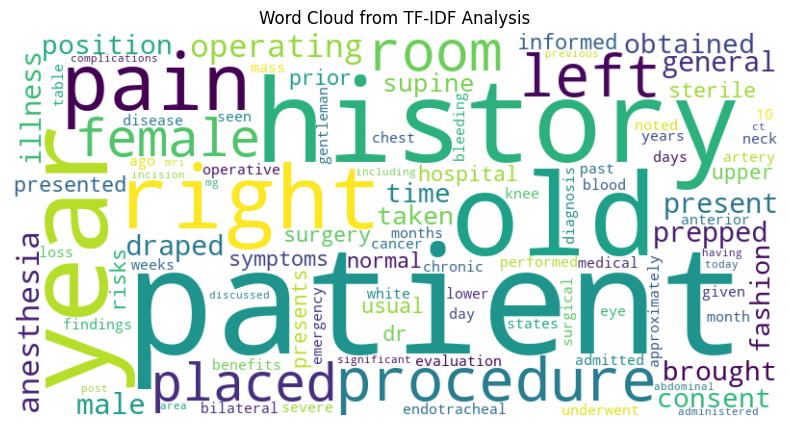

          Token  TF-IDF Score
4372    patient    107.271781
2840    history     59.410534
6620       year     58.475417
4146        old     58.433711
5175      right     53.936257
4280       pain     43.053683
4732  procedure     42.231266
3415       left     40.895130
5199       room     37.019998
4523     placed     35.078260


In [187]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def tfidf_analysis_and_wordcloud(df, column, max_words=100, top_n=10):
    """
    Generates a word cloud based on TF-IDF analysis of the specified column in the DataFrame.
    Also outputs the top N tokens with the highest TF-IDF scores.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The name of the column containing text data.
    max_words (int): The maximum number of words to display in the word cloud.
    top_n (int): The number of top tokens to display based on TF-IDF scores.
    
    Returns:
    pd.DataFrame: DataFrame containing the top N tokens and their TF-IDF scores.
    """
    # Initialize the TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(stop_words='english')
    
    # Fit and transform the text data
    tfidf_matrix = vectorizer.fit_transform(df[column])
    
    # Get the feature names (words)
    feature_names = vectorizer.get_feature_names_out()
    
    # Sum the TF-IDF scores for each word
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    
    # Create a dictionary of words and their corresponding TF-IDF scores
    tfidf_dict = dict(zip(feature_names, tfidf_scores))
    
    # Convert the dictionary to a DataFrame for easier analysis
    tfidf_df = pd.DataFrame(list(tfidf_dict.items()), columns=['Token', 'TF-IDF Score'])
    
    # Sort the DataFrame by TF-IDF Score in descending order
    tfidf_df = tfidf_df.sort_values(by='TF-IDF Score', ascending=False)
    
    # Get the top N tokens
    top_tokens = tfidf_df.head(top_n)
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=max_words, background_color='white').generate_from_frequencies(tfidf_dict)
    
    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud from TF-IDF Analysis')
    plt.show()
    
    # Output the top N tokens with the highest TF-IDF scores
    return top_tokens

# Call the function with the DataFrame and the column name
top_tokens = tfidf_analysis_and_wordcloud(df, 'extracted_text')

# Display the top tokens
print(top_tokens)